In [24]:
%matplotlib inline
import cd_diagrams as cdd
import importlib
import pandas as pd
import numpy as np
import amir_tools as at
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import functools as ft
import matplotlib
import warnings
from matplotlib.colors import LinearSegmentedColormap

matplotlib.rc_file_defaults()
datasets = ["ChapmanShaoxing","CPSC2018","PTBXL"]
models = ["inception","minirocket","xresnet1d101"]

In [6]:
def get_scaling_experiments(model_name,dataset,clf_numbers=True,dataset_numbers=True):
    # loads the experiment results
    experiments = []
    for sc in ["0.1","0.25","0.5","0.75","1.0"]:
        try:
            for i in range(20):
                df = pd.read_csv("models/scaling/csvs/%s_%s_sc-n_%s_%s.csv"%(model_name,dataset,sc,i))
                df = df[df.columns[0:-4]]
                df = df.loc[df["index"]=="f1-score"]
                df = df.rename(columns={"index":"classifier_name"})
                df["classifier_name"] = model_name if clf_numbers==False else "%s_%s"%(model_name,sc)
                df["dataset_name"] = dataset if dataset_numbers==False else "%s_%s"%(dataset,i)
                df.index = [i]
                experiments.append(df)
        except Exception as  e:
            print(e)
            continue
    exp_df = pd.concat(experiments)
    return exp_df

def make_cdd_df(exp_df):
    df_median = exp_df.reset_index()[["classifier_name","dataset_name",]]
    df_median["value"] = list(exp_df[exp_df.columns[1:-1]].mean(axis=1).values)
    df_median.columns = ["classifier_name","dataset_name","accuracy"]
    return df_median

def cd_diagram_single_model(exp_df,title="Mean F1",labels=False):
    df_median = make_cdd_df(exp_df)
    cdd.draw_cd_diagram(df_perf=df_median, title=title, labels=labels,alpha=0.05)
    
def draw_scatter_plot(exp_df):
    sns.set(rc = {'figure.figsize':(30,8)})
    sns.set(font_scale = 3)
    data = exp_df.melt(id_vars = "classifier_name")
    data["variable"] = [at.label_shortner(x) for x in data["variable"]]

    #sns.boxplot(data=data,hue="classifier_name",x="variable",y="value",)
    ax = sns.stripplot(data=data,hue="classifier_name",x="variable",y="value",dodge=True,size=8, edgecolor='gray',)
    ax.set_xticklabels(ax.get_xticklabels(),fontsize=20,rotation=45)
    ax.set_xlabel("", fontsize = 25)
    ax.set_ylabel("F1 Values", fontsize = 25)
    # ax.set_title("Expriment Results for MiniRocket on CPSC", fontsize = 25)
#     plt.legend( fontsize = 16)
#     plt.tight_layout()
    ax.legend(bbox_to_anchor=(1., 1), loc=2, borderaxespad=0.)
    return plt

## per model analysis

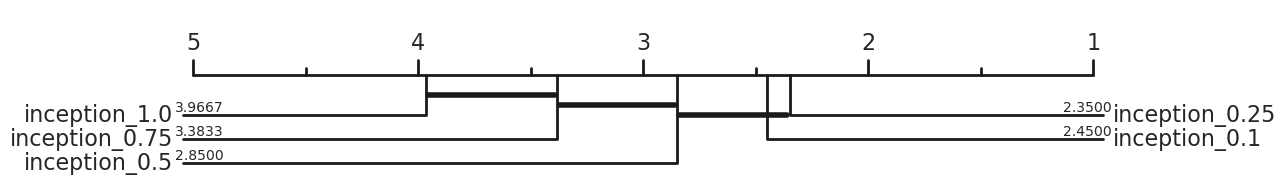

In [134]:
datasets = ["ChapmanShaoxing","CPSC2018","PTBXL"]
inception_dfs = []
for dataset in datasets:
    model_name = "inception"
    exp_df = get_scaling_experiments(model_name,dataset)
    inception_dfs.append(exp_df)
df_inception = pd.concat([make_cdd_df(x) for x in inception_dfs])
plt,_,_ = cdd.draw_cd_diagram(df_perf=df_inception,alpha=0.05,labels=True)
fig.savefig('images/%s_performance_all.pdf'%model_name)

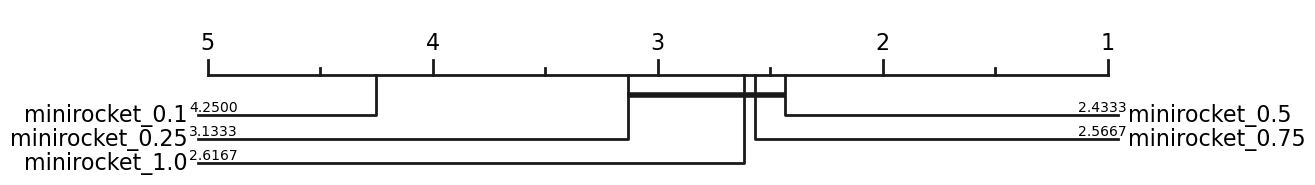

In [18]:
minirocket_dfs = []
for dataset in datasets:
    model_name = "minirocket"
    exp_df = get_scaling_experiments(model_name,dataset)
    minirocket_dfs.append(exp_df)
df_minirocket = pd.concat([make_cdd_df(x) for x in minirocket_dfs])
plt,_,_ = cdd.draw_cd_diagram(df_perf=df_minirocket,alpha=0.05,labels=True)
fig.savefig('images/%s_performance_all.pdf'%model_name)

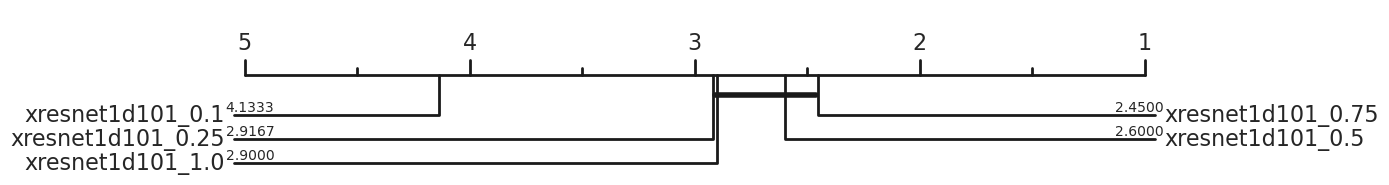

In [285]:
xresnet_dfs = []
for dataset in datasets:
    model_name = "xresnet1d101"
    exp_df = get_scaling_experiments(model_name,dataset)
    xresnet_dfs.append(exp_df)
df_xresnet = pd.concat([make_cdd_df(x) for x in xresnet_dfs])
plt,_,_ = cdd.draw_cd_diagram(df_perf=df_xresnet,alpha=0.05,labels=True)
fig.savefig('images/%s_performance_all.pdf'%model_name)

# correlations between sampling rate and performance (per model)

In [287]:
# need a dataframe with columns : disease sampling_rate F1_score
dataset_names = {0:"chapmanShaoxing",1:"CPSC",2:"PTBXL"}
corr_dfs = []
model_dfs = minirocket_dfs
for df in model_dfs:
    corr_dfs.append(df[df.columns[0:-1]].melt(id_vars=["classifier_name"]))
corr_df = pd.concat(corr_dfs).drop(columns=["variable"])
corr_df["classifier_name"] = corr_df["classifier_name"].transform(lambda x: float(x.split("_")[-1])*500)
print("overall:",corr_df.corr()["value"][0])
# for each dataset
for i,df in enumerate(model_dfs):
    corr_df = df[df.columns[0:-1]].melt(id_vars=["classifier_name"]).drop(columns=["variable"])
    corr_df["classifier_name"] = corr_df["classifier_name"].transform(lambda x: float(x.split("_")[-1])*500)
    print(dataset_names[i],corr_df.corr()["value"][0])

overall: 0.026242440872476017
chapmanShaoxing 0.01019196641527223
CPSC 0.017223779294411126
PTBXL 0.05282010440207263


In [288]:
# need a dataframe with columns : disease sampling_rate F1_score
dataset_names = {0:"chapmanShaoxing",1:"CPSC",2:"PTBXL"}
corr_dfs = []
model_dfs = inception_dfs
for df in model_dfs:
    corr_dfs.append(df[df.columns[0:-1]].melt(id_vars=["classifier_name"]))
corr_df = pd.concat(corr_dfs).drop(columns=["variable"])
corr_df["classifier_name"] = corr_df["classifier_name"].transform(lambda x: float(x.split("_")[-1])*500)
print("overall:",corr_df.corr()["value"][0])
# for each dataset
for i,df in enumerate(model_dfs):
    corr_df = df[df.columns[0:-1]].melt(id_vars=["classifier_name"]).drop(columns=["variable"])
    corr_df["classifier_name"] = corr_df["classifier_name"].transform(lambda x: float(x.split("_")[-1])*500)
    print(dataset_names[i],corr_df.corr()["value"][0])

overall: -0.05466985686638936
chapmanShaoxing -0.035562102925732475
CPSC -0.15367028578818137
PTBXL -0.0027900099697245866


In [289]:
# need a dataframe with columns : disease sampling_rate F1_score
dataset_names = {0:"chapmanShaoxing",1:"CPSC",2:"PTBXL"}
corr_dfs = []
model_dfs = xresnet_dfs
for df in model_dfs:
    corr_dfs.append(df[df.columns[0:-1]].melt(id_vars=["classifier_name"]))
corr_df = pd.concat(corr_dfs).drop(columns=["variable"])
corr_df["classifier_name"] = corr_df["classifier_name"].transform(lambda x: float(x.split("_")[-1])*500)
print("overall:",corr_df.corr()["value"][0])
# for each dataset
for i,df in enumerate(model_dfs):
    corr_df = df[df.columns[0:-1]].melt(id_vars=["classifier_name"]).drop(columns=["variable"])
    corr_df["classifier_name"] = corr_df["classifier_name"].transform(lambda x: float(x.split("_")[-1])*500)
    print(dataset_names[i],corr_df.corr()["value"][0])

overall: 0.05358289327976431
chapmanShaoxing 0.0832890130143354
CPSC -0.09249273174940315
PTBXL 0.11086701140983751


# correlation for each dataset (performance)

In [305]:
dset_num = 2 # 0->chapman,1->cpsc, 2->ptbxl
dataset_names = {0:"chapmanShaoxing",1:"CPSC",2:"PTBXL"}
disease_list = minirocket_dfs[dset_num].columns[1:-1]
dataset_dfs = []
df = pd.concat([minirocket_dfs[dset_num],inception_dfs[dset_num],xresnet_dfs[dset_num]]) 
# now for each disease in disease_list, do the analysis
disease_dict = {}
for disease_name in disease_list:
    df_perf = df[["classifier_name","dataset_name",disease_name]]
    df_perf = df_perf.rename(columns={disease_name:"accuracy"})


# correlation for all models and datasets (using performance)

In [306]:

dataset_names = {0:"chapmanShaoxing",1:"CPSC",2:"PTBXL"}
corr_dfs = []
model_corr_dfs = []
model_dfs = minirocket_dfs
for df in model_dfs:
    corr_dfs.append(df[df.columns[0:-1]].melt(id_vars=["classifier_name"]))
corr_df = pd.concat(corr_dfs).drop(columns=["variable"])
corr_df["classifier_name"] = corr_df["classifier_name"].transform(lambda x: float(x.split("_")[-1])*500)
model_corr_dfs.append(corr_df)

model_dfs = inception_dfs
for df in model_dfs:
    corr_dfs.append(df[df.columns[0:-1]].melt(id_vars=["classifier_name"]))
corr_df = pd.concat(corr_dfs).drop(columns=["variable"])
corr_df["classifier_name"] = corr_df["classifier_name"].transform(lambda x: float(x.split("_")[-1])*500)
model_corr_dfs.append(corr_df)

model_dfs = xresnet_dfs
for df in model_dfs:
    corr_dfs.append(df[df.columns[0:-1]].melt(id_vars=["classifier_name"]))
corr_df = pd.concat(corr_dfs).drop(columns=["variable"])
corr_df["classifier_name"] = corr_df["classifier_name"].transform(lambda x: float(x.split("_")[-1])*500)
model_corr_dfs.append(corr_df)
pd.concat(model_corr_dfs).corr()


,classifier_name,value
classifier_name,1.00000,0.00381
value,0.00381,1.00000


# per disease analysis

In [ ]:
# first, select a dataset
# treat each disease as its own dataset, and run the cd analysis for all models. 
# classifier_name -> model+sc
# dataset_name -> disease+dataset (in case there are duplicates)
# acc -> F1 measure

correlation for PTBXL 0.15456041913962368


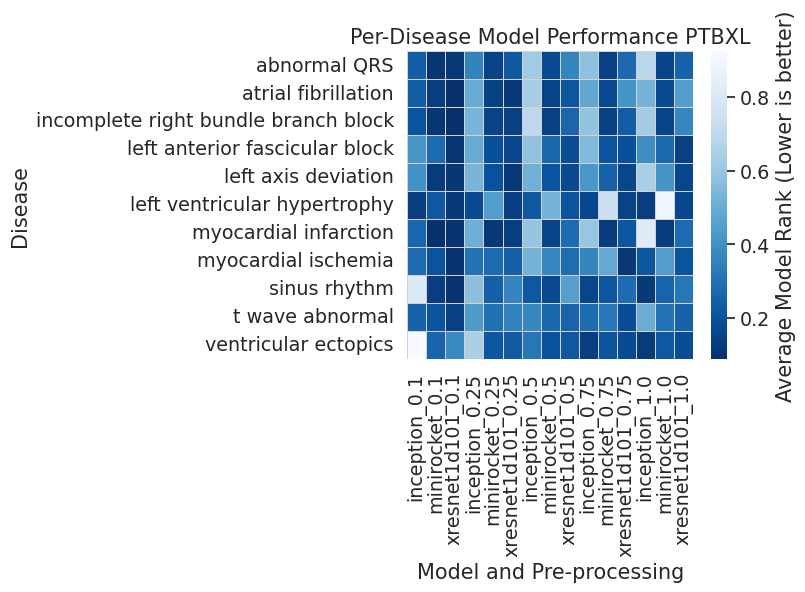

In [246]:

dset_num = 2 # 0->chapman,1->cpsc, 2->ptbxl
dataset_names = {0:"chapmanShaoxing",1:"CPSC",2:"PTBXL"}
disease_list = minirocket_dfs[dset_num].columns[1:-1]
dataset_dfs = []
df = pd.concat([minirocket_dfs[dset_num],inception_dfs[dset_num],xresnet_dfs[dset_num]]) 
# now for each disease in disease_list, do the analysis
disease_dict = {}
for disease_name in disease_list:
    df_perf = df[["classifier_name","dataset_name",disease_name]]
    df_perf = df_perf.rename(columns={disease_name:"accuracy"})
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        a,disease_dict[disease_name],b = cdd.wilcoxon_holm(df_perf=df_perf, alpha=0.05,ranking="MRR")

hm_df = pd.DataFrame(disease_dict).T
hm_df = hm_df[hm_df.columns[np.argsort([float(i.split("_")[-1]) for i in hm_df.columns])]] # sort by scaling value

# correlation
corr_df = hm_df.reset_index().melt(id_vars=["index"]).drop(columns="index")
corr_df["variable"] = corr_df["variable"].apply(lambda x: float(x.split("_")[-1])*500)
print("correlation for "+dataset_names[dset_num], corr_df.corr()["value"][0])
### 
ax = sns.heatmap(hm_df, linewidths=.5, linecolor='lightgray',cmap=sns.color_palette("Blues", as_cmap=True).reversed())

sns.set(rc = {'figure.figsize':(8,6)})
sns.set(font_scale = 1.25)

# Manually specify colorbar labelling after it's been generated
# colorbar = ax.collections[0].colorbar
# colorbar.set_ticks([-1, 0, 1])
# colorbar.set_ticklabels(['B', 'A', 'C'])
# X - Y axis labels
ax.set_ylabel('Disease')
ax.set_xlabel('Model and Pre-processing')
ax.set_title("Per-Disease Model Performance %s"%dataset_names[dset_num])
colorbar = ax.collections[0].colorbar
# colorbar.set_ticks([])

colorbar.ax.set_ylabel('Average Model Rank (Lower is better)',)

# Only y-axis labels need their rotation set, x-axis labels already have a rotation of 0
# _, labels = plt.yticks()
# plt.setp(labels, rotation=0)
fig = ax.get_figure()
fig.tight_layout() 
fig.savefig('images/Per-Disease_Model_Performance_%s.pdf'%dataset_names[dset_num])

In [351]:
# all datasets combined 
importlib.reload(cdd)
dataset_names = {0:"chapman",1:"CPSC",2:"PTBXL"}

disease_dict = {}
for dset_num in range(3):
    disease_list = minirocket_dfs[dset_num].columns[1:-1]
    df = pd.concat([minirocket_dfs[dset_num],inception_dfs[dset_num],xresnet_dfs[dset_num]]) 
    # now for each disease in disease_list, do the analysis

    for disease_name in disease_list:
        df_perf = df[["classifier_name","dataset_name",disease_name]]
        df_perf = df_perf.rename(columns={disease_name:"accuracy"})
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            disease_dict[disease_name+"-"+dataset_names[dset_num]] = cdd.wilcoxon_holm(df_perf=df_perf, alpha=0.05,)[1]



hm_df = pd.DataFrame(disease_dict).T
hm_df.shape

(26, 15)

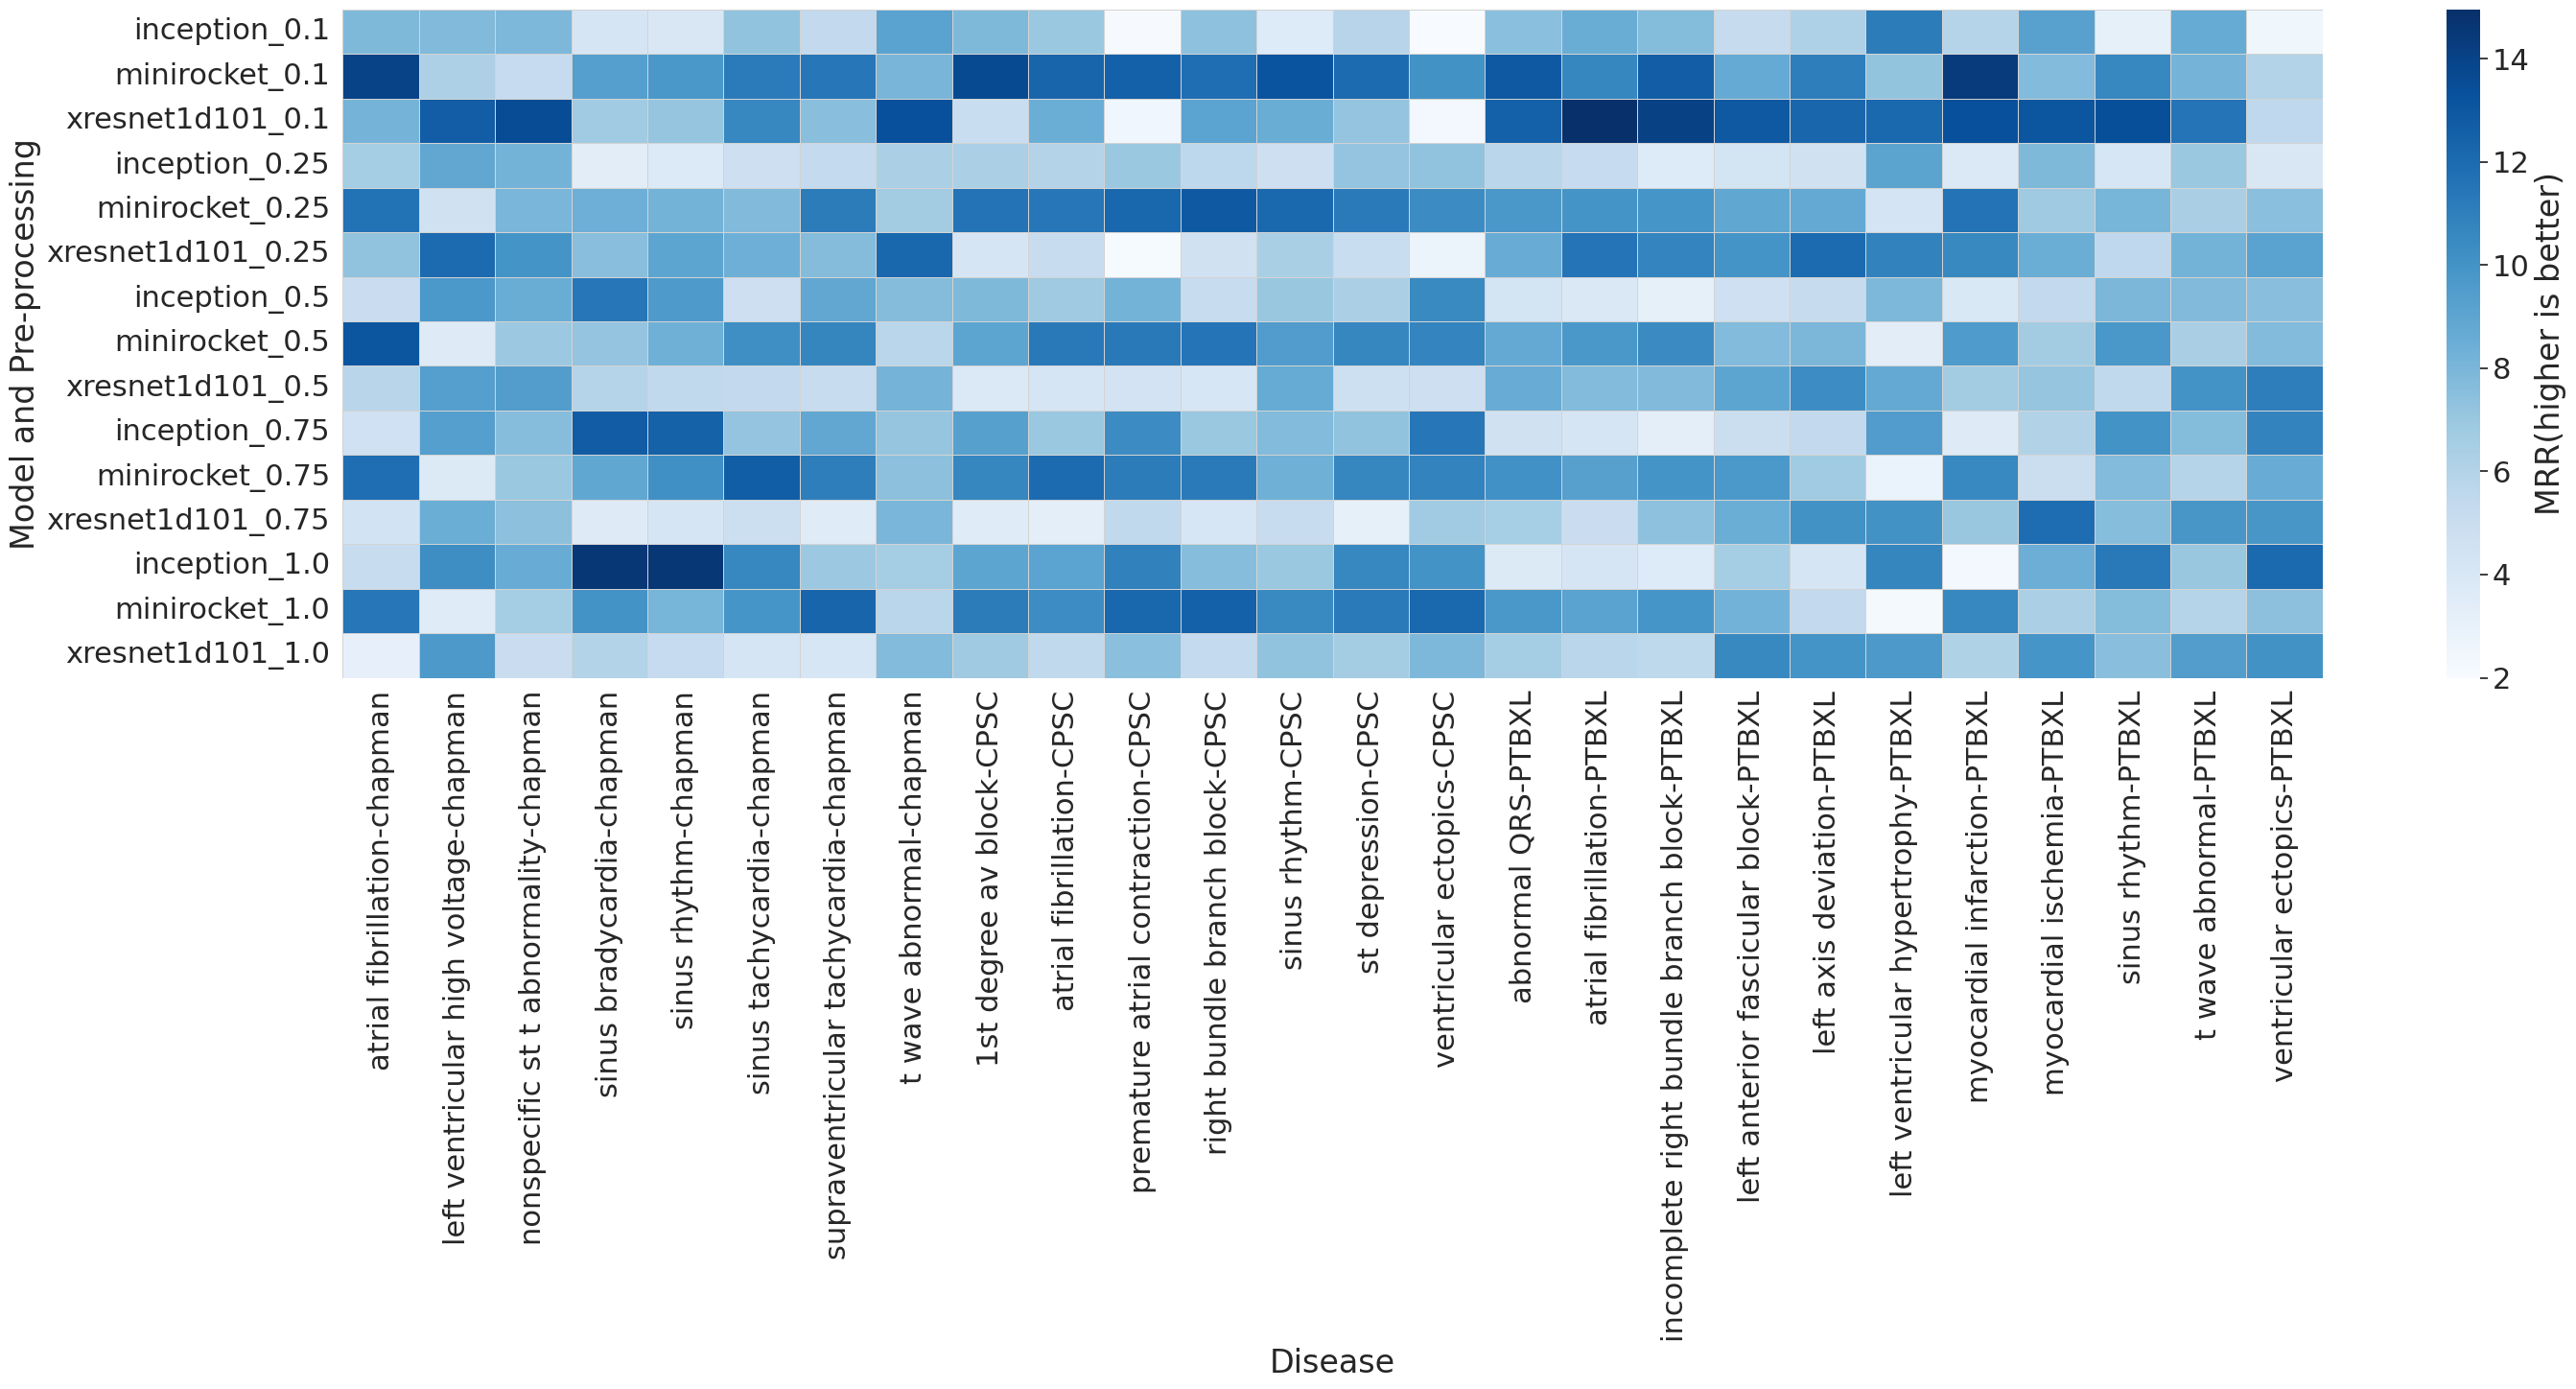

In [352]:
hm_df = pd.DataFrame(disease_dict).T
hm_df = hm_df[hm_df.columns[np.argsort([float(i.split("_")[-1]) for i in hm_df.columns])]] # sort by scaling value

ax = sns.heatmap(hm_df.T, linewidths=.5, linecolor='lightgray',cmap=sns.color_palette("Blues", as_cmap=True))

sns.set(rc = {'figure.figsize':(30,15)})
sns.set(font_scale = 2)

# Manually specify colorbar labelling after it's been generated
# colorbar = ax.collections[0].colorbar
# colorbar.set_ticks([-1, 0, 1])
# colorbar.set_ticklabels(['B', 'A', 'C'])
# X - Y axis labels
ax.set_xlabel('Disease')
ax.set_ylabel('Model and Pre-processing')
# ax.set_title("Per-Disease Model Performance "%dataset_names[dset_num])
colorbar = ax.collections[0].colorbar
# colorbar.set_ticks([])

colorbar.ax.set_ylabel('MRR(higher is better)',)

# Only y-axis labels need their rotation set, x-axis labels already have a rotation of 0
# _, labels = plt.yticks()
# plt.setp(labels, rotation=0)
fig = ax.get_figure()
fig.tight_layout() 
fig.savefig('images/Per-Disease_Model_Performance_all.pdf')

# correlation between sampling rate and ranks
- for all
- for all models

In [353]:
# per model
corr_df = hm_df.T
corr_df = corr_df.reset_index().melt(id_vars=["index"]).drop(columns=["variable"]) 
corr_df["index"] = corr_df["index"].apply(lambda x: float(x.split("_")[-1])*500)
corr_df
corr_df.corr(method="spearman")

,index,value
index,1.000000,-0.074871
value,-0.074871,1.000000


In [354]:
# per model


for m in models:
    corr_df = hm_df.T
    corr_df = corr_df[corr_df.index.str.contains(m)].reset_index().melt(id_vars=["index"]).drop(columns=["variable"]) 
    corr_df["index"] = corr_df["index"].apply(lambda x: float(x.split("_")[-1])*500)
    
    print(m,corr_df.corr(method="spearman")["value"][0])

inception 0.2662065879335514
minirocket -0.17017624198802214
xresnet1d101 -0.3233137408798818


# correlations

In [ ]:
# all datasets combined 
importlib.reload(cdd)
dataset_names = {0:"chapman",1:"CPSC",2:"PTBXL"}

disease_dict = {}
for dset_num in range(3):
    disease_list = minirocket_dfs[dset_num].columns[1:-1]
    df = pd.concat([minirocket_dfs[dset_num],inception_dfs[dset_num],xresnet_dfs[dset_num]]) 
    # now for each disease in disease_list, do the analysis

    for disease_name in disease_list:
        df_perf = df[["classifier_name","dataset_name",disease_name]]
        df_perf = df_perf.rename(columns={disease_name:"accuracy"})
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            disease_dict[disease_name+"-"+dataset_names[dset_num]] = cdd.wilcoxon_holm(df_perf=df_perf, alpha=0.05,)[1]



hm_df = pd.DataFrame(disease_dict).T
hm_df

In [262]:
df

,classifier_name,abnormal QRS,atrial fibrillation,incomplete right bundle branch block,left anterior fascicular block,left axis deviation,left ventricular hypertrophy,myocardial infarction,myocardial ischemia,sinus rhythm,t wave abnormal,ventricular ectopics,dataset_name
0,minirocket_0.1,0.513274,0.738255,0.472222,0.697531,0.745732,0.554667,0.639668,0.593838,0.944969,0.493333,0.660099,PTBXL_0
1,minirocket_0.1,0.504472,0.802508,0.524064,0.715116,0.740402,0.547264,0.671727,0.637975,0.942371,0.472019,0.685714,PTBXL_1
2,minirocket_0.1,0.498350,0.788462,0.371585,0.777202,0.767273,0.612245,0.621622,0.668213,0.936206,0.459227,0.666667,PTBXL_2
3,minirocket_0.1,0.434783,0.749226,0.504202,0.770833,0.750229,0.544000,0.631373,0.660674,0.943575,0.447236,0.647887,PTBXL_3
4,minirocket_0.1,0.519562,0.757962,0.541284,0.806366,0.740173,0.551220,0.625000,0.634361,0.937743,0.459397,0.589286,PTBXL_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,xresnet1d101_1.0,0.582492,0.849840,0.608696,0.740113,0.774697,0.529703,0.723684,0.651042,0.948380,0.335260,0.480874,PTBXL_15
16,xresnet1d101_1.0,0.459290,0.721088,0.595960,0.721003,0.759176,0.570776,0.692230,0.624658,0.940092,0.160000,0.536170,PTBXL_16
17,xresnet1d101_1.0,0.576029,0.797468,0.564516,0.744898,0.760791,0.442368,0.715564,0.379562,0.944187,0.503846,0.520231,PTBXL_17
18,xresnet1d101_1.0,0.496032,0.829268,0.647343,0.689873,0.747296,0.569343,0.702479,0.622691,0.944655,0.299401,0.632124,PTBXL_18


## per dataset analysis
- classifier_names = model_HZ
- dataset name = datset + bootstrap#
- accuracy = F1

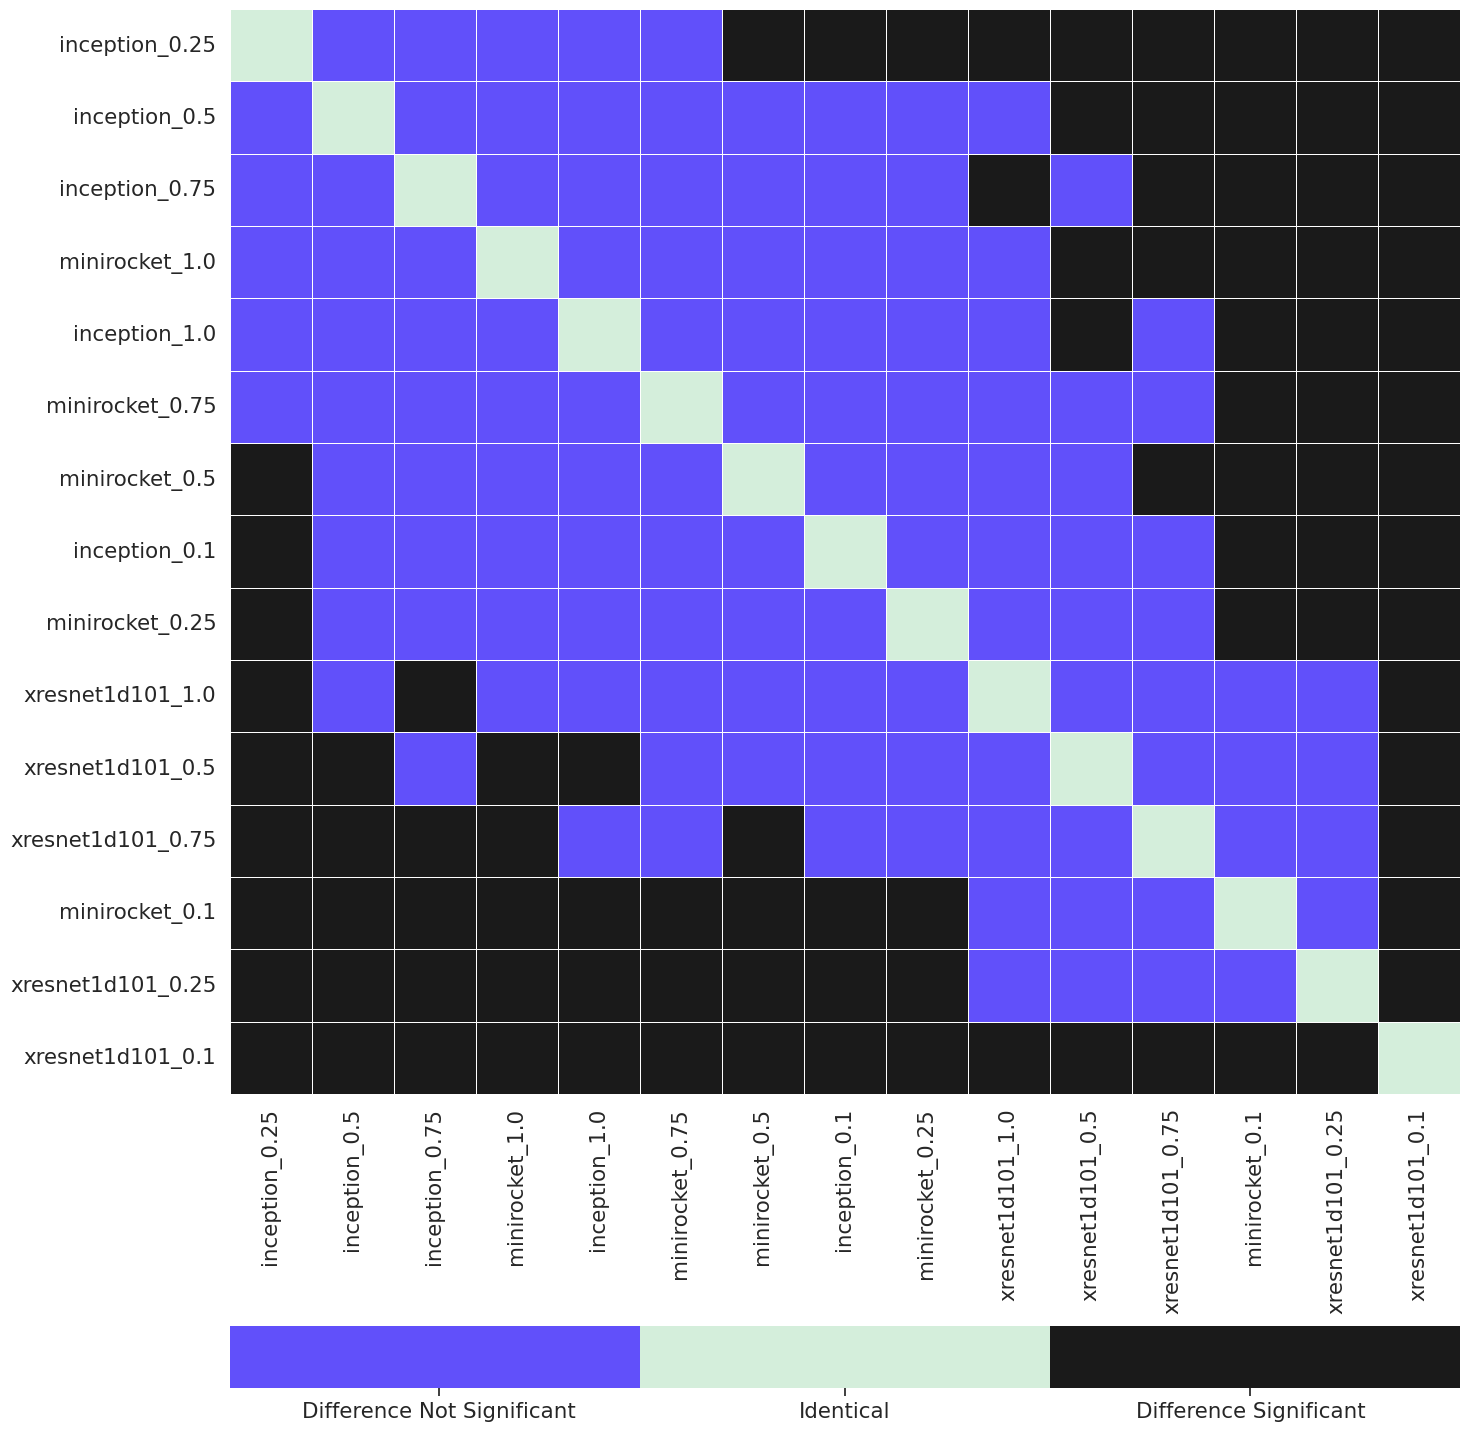

In [25]:
dataset = "PTBXL"
dataset_dfs = []
for model_name in models[0:3]:
    exp_df = get_scaling_experiments(model_name,dataset)
    dataset_dfs.append(exp_df)
p_vals,avg_rank,_ = cdd.wilcoxon_holm(df_perf=pd.concat([make_cdd_df(x) for x in dataset_dfs]), alpha=0.05)
# given a model, find whether it's significantly better than the one ranked below it
m_list = list(avg_rank.index)  #sorted list of models by avg rank
p_vals = pd.DataFrame(p_vals)
# make a matrix of which models is significantly better than the others
rank_matrix = pd.DataFrame(-1*np.ones([len(m_list),len(m_list)]),index=reversed(m_list),columns=reversed(m_list))
i = 0
for m1 in m_list:
    for m2 in list(reversed(m_list)):
        row = p_vals[((p_vals[0]==m1) & (p_vals[1]==m2)) | (p_vals[1]==m1) & (p_vals[0]==m2)]
        if row.shape[0]>0:
            if row[3].values[0] == True:
                rank_matrix.loc[m1][m2] = 1
        else: 
            rank_matrix.loc[m1][m2] = 0
            
myColors = ((0.1, 0.0, 1, 0.66),(0.5, 1, .5,0.2),(0.1, 0.1, 0.1, 1),)
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))
sns.set(rc = {'figure.figsize':(15,16)})
sns.set(font_scale = 1.4)
ax = sns.heatmap(rank_matrix, cmap=cmap, linewidths=0.5,cbar_kws={"orientation": "horizontal"})
# ax.set_title("Model Comparisons for %s"%dataset)
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.66, 0, .66])

colorbar.set_ticklabels(['Difference Not Significant', 'Identical', 'Difference Significant'])
ax.tick_params(axis='x', rotation=90)
fig = ax.get_figure()
fig.tight_layout() 
fig.savefig('images/model_comparisons_%s.pdf'%dataset)

## all models, all datasets
- classifier_names = model_HZ
- dataset name = datset + bootstrap#
- accuracy = F1
### Method 1, pool all performane dfs together and run test
### Method 2, get rank matrices, and average them 

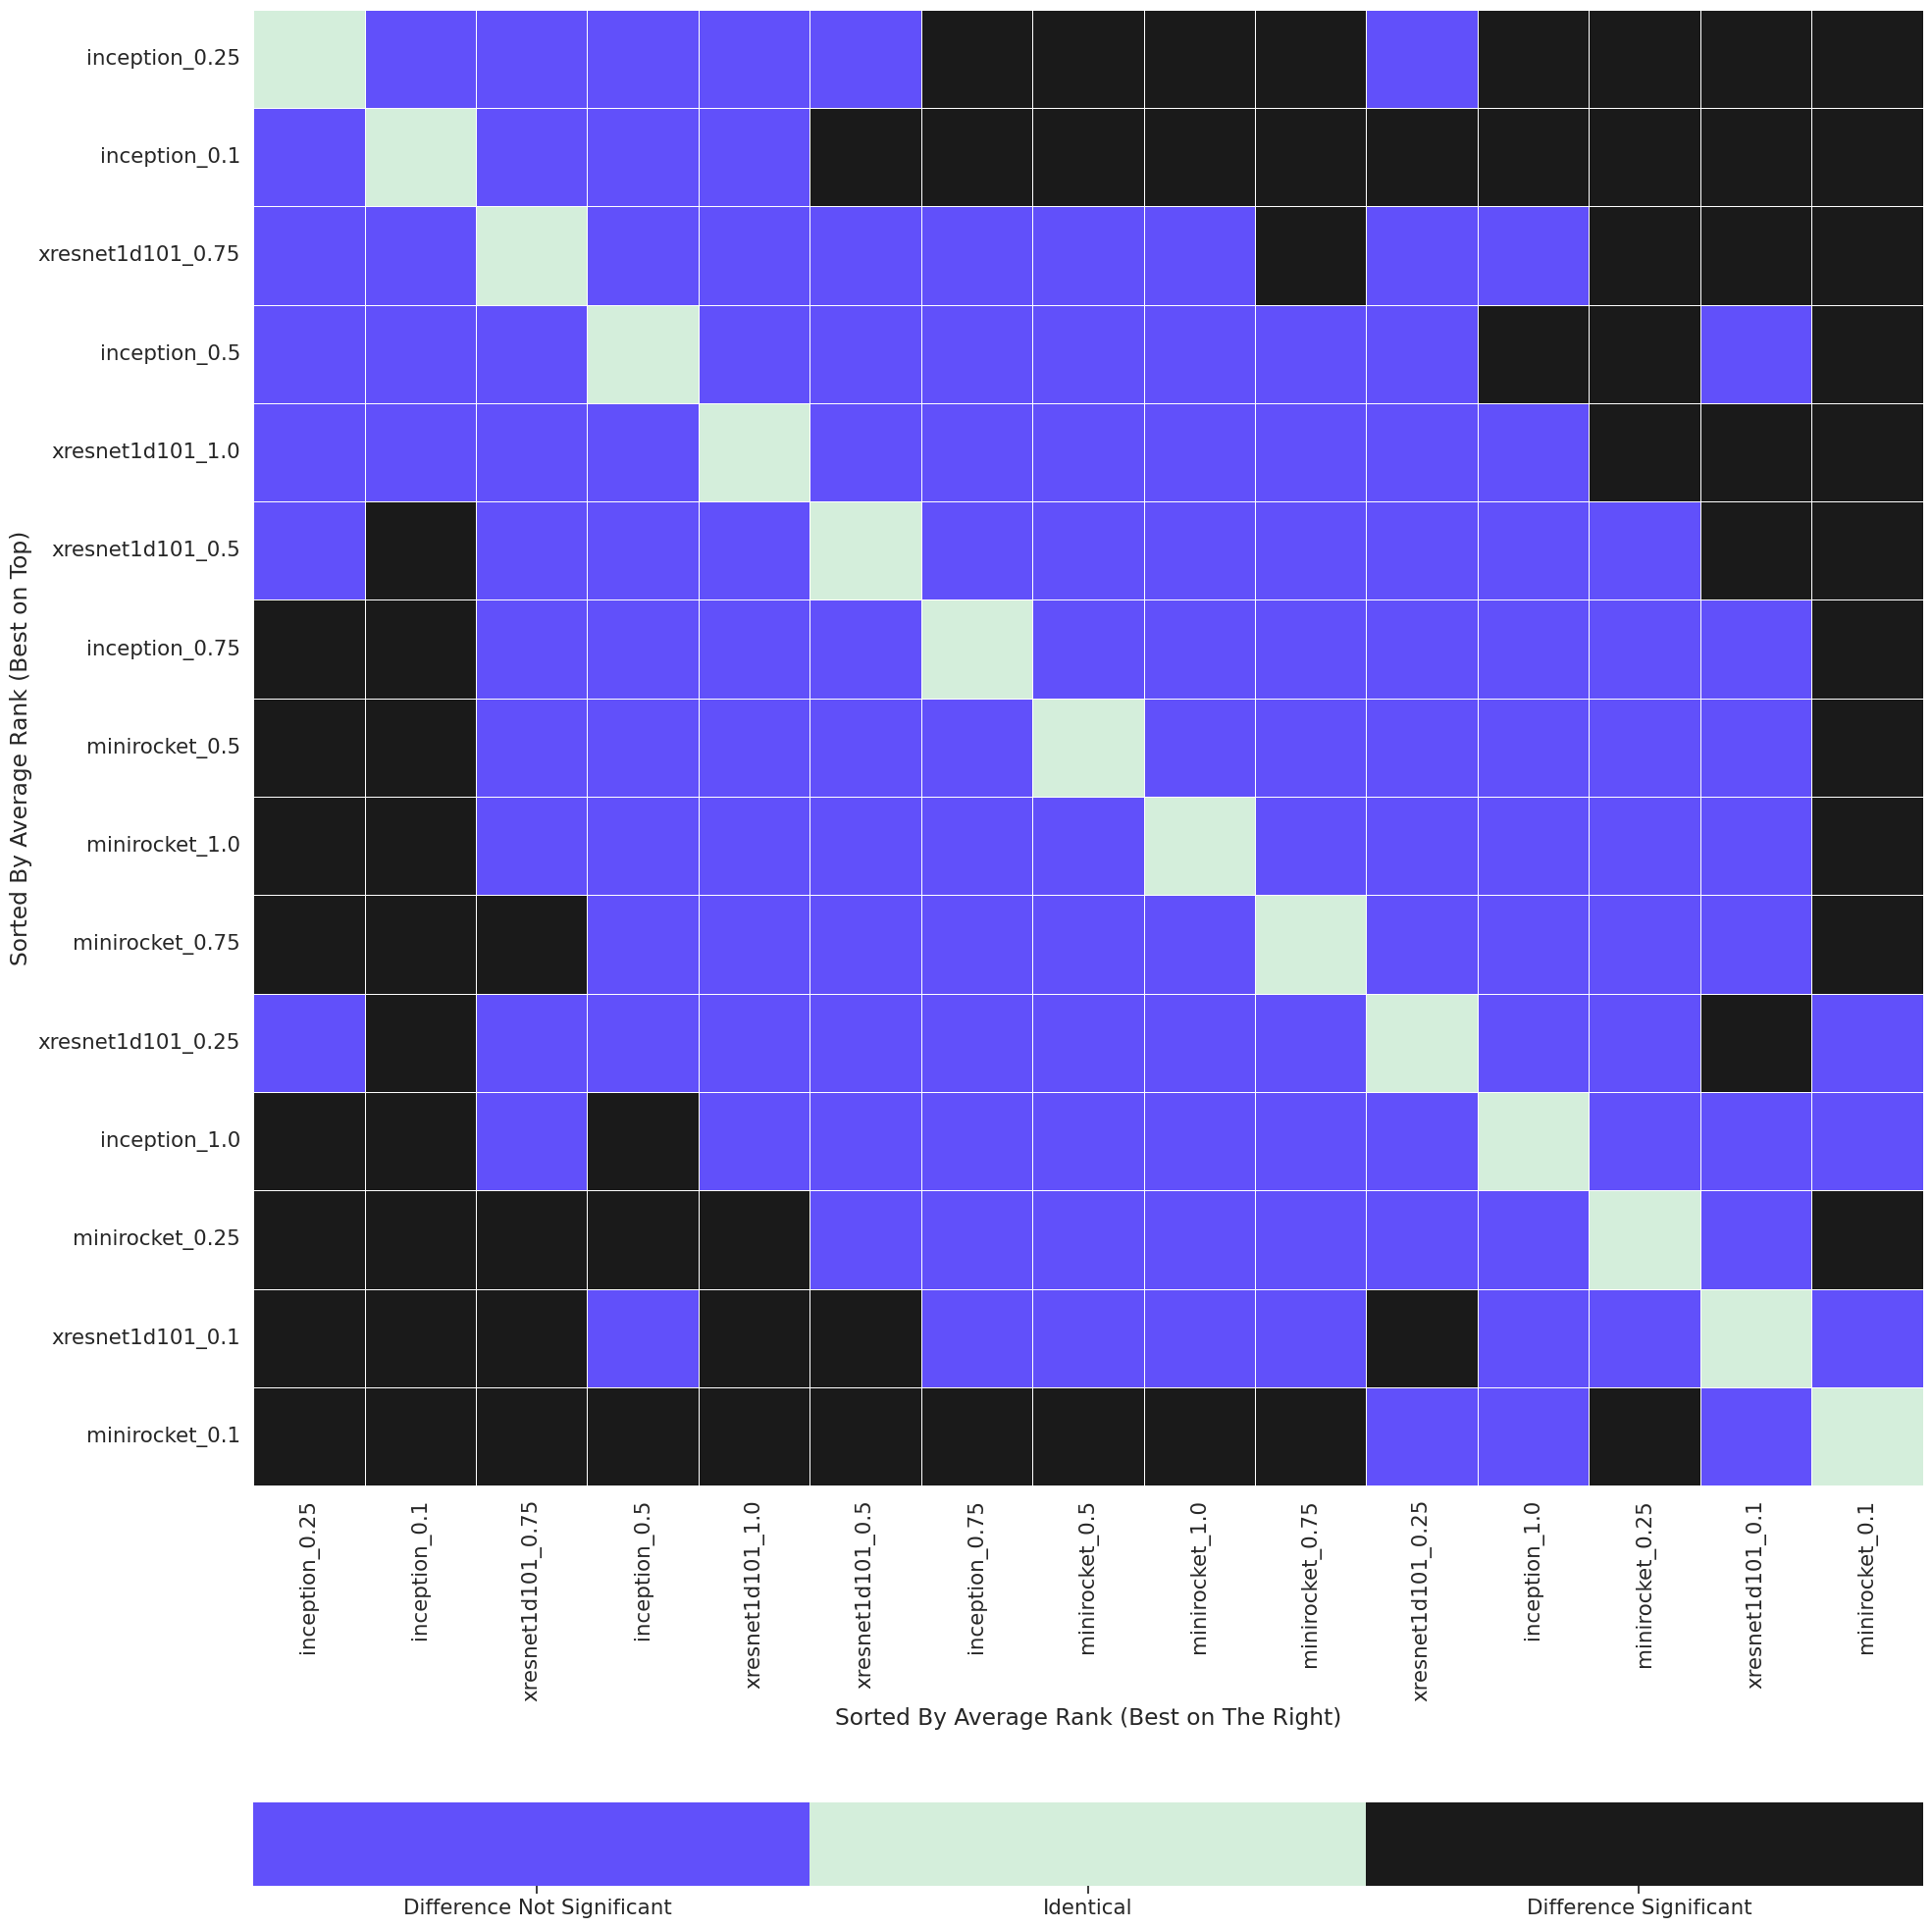

In [26]:
dataset_dfs = []
for model_name in models[0:3]:
    for dataset in datasets:
        exp_df = get_scaling_experiments(model_name,dataset)
        dataset_dfs.append(exp_df)
p_vals,avg_rank,_ = cdd.wilcoxon_holm(df_perf=pd.concat([make_cdd_df(x) for x in dataset_dfs]), alpha=0.05)
# given a model, find whether it's significantly better than the one ranked below it
m_list = list(avg_rank.index)  #sorted list of models by avg rank
p_vals = pd.DataFrame(p_vals)
# make a matrix of which models is significantly better than the others
rank_matrix = pd.DataFrame(-1*np.ones([len(m_list),len(m_list)]),index=reversed(m_list),columns=reversed(m_list))
i = 0
for m1 in m_list:
    for m2 in list(reversed(m_list)):
        row = p_vals[((p_vals[0]==m1) & (p_vals[1]==m2)) | (p_vals[1]==m1) & (p_vals[0]==m2)]
        if row.shape[0]>0:
            if row[3].values[0] == True:
                rank_matrix.loc[m1][m2] = 1
        else: 
            rank_matrix.loc[m1][m2] = 0
myColors = ((0.1, 0.0, 1, 0.66),(0.5, 1, .5,0.2),(0.1, 0.1, 0.1, 1),)
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))
sns.set(rc = {'figure.figsize':(20,22)})
sns.set(font_scale = 1.4)
ax = sns.heatmap(rank_matrix, cmap=cmap, linewidths=0.5,cbar_kws={"orientation": "horizontal"})
# ax.set_title("Model Comparisons for All Datasets")
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.66, 0, .66])

colorbar.set_ticklabels(['Difference Not Significant', 'Identical', 'Difference Significant'])
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel('Sorted By Average Rank (Best on Top)')
ax.set_xlabel('Sorted By Average Rank (Best on The Right)')
fig = ax.get_figure()
fig.tight_layout() 
fig.savefig('images/model_comparisons_alldatasets.pdf')

In [27]:
# Method 2
dataset_dfs = []
avg_ranks = []
for dataset in datasets:
    for model_name in models[0:3]:
        exp_df = get_scaling_experiments(model_name,dataset)
        dataset_dfs.append(exp_df)
    p_vals,avg_rank,_ = cdd.wilcoxon_holm(df_perf=pd.concat([make_cdd_df(x) for x in dataset_dfs]), alpha=0.05)
    avg_ranks.append(avg_rank)
(sum(avg_ranks)/len(avg_ranks)).sort_values()

inception_0.1         5.075000
inception_0.25        5.172222
xresnet1d101_0.75     5.380556
xresnet1d101_1.0      5.755556
xresnet1d101_0.5      6.672222
minirocket_0.5        7.675000
inception_0.5         7.847222
minirocket_1.0        8.391667
minirocket_0.75       8.472222
inception_0.75        8.494444
minirocket_0.25       8.891667
xresnet1d101_0.25     9.216667
inception_1.0        10.441667
minirocket_0.1       11.150000
xresnet1d101_0.1     11.363889
dtype: float64

# other stuff

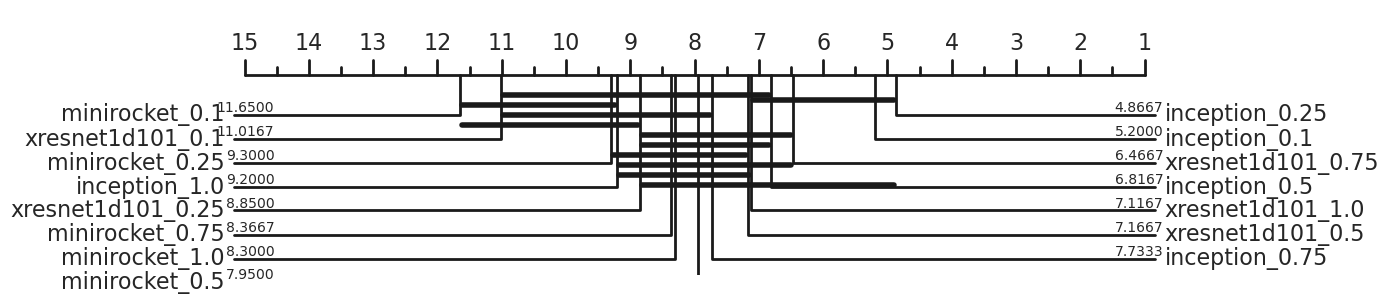

In [28]:
importlib.reload(cdd)
df_perf = pd.concat([df_xresnet,df_inception,df_minirocket])
plt,p_vals,avg_rank = cdd.draw_cd_diagram(df_perf=df_perf,alpha=0.05,labels=True,)

In [ ]:
stats = pd.DataFrame(p_vals,columns=["model_1","model_2","p_val","significant"])
# stats[(stats["model_1"]=="inception_1.0")]
avg_rank

# scatter plots

In [ ]:

for dataset in datasets:
    model_name = "minirocket"
    exp_df = get_scaling_experiments(model_name,dataset,dataset_numbers=False)
exp_df = exp_df.drop(columns=["dataset_name"])
plt = draw_scatter_plot(exp_df)
# ax.set_title("Expriment Results for MiniRocket on CPSC", fontsize = 25)

NameError: name 'ax' is not defined

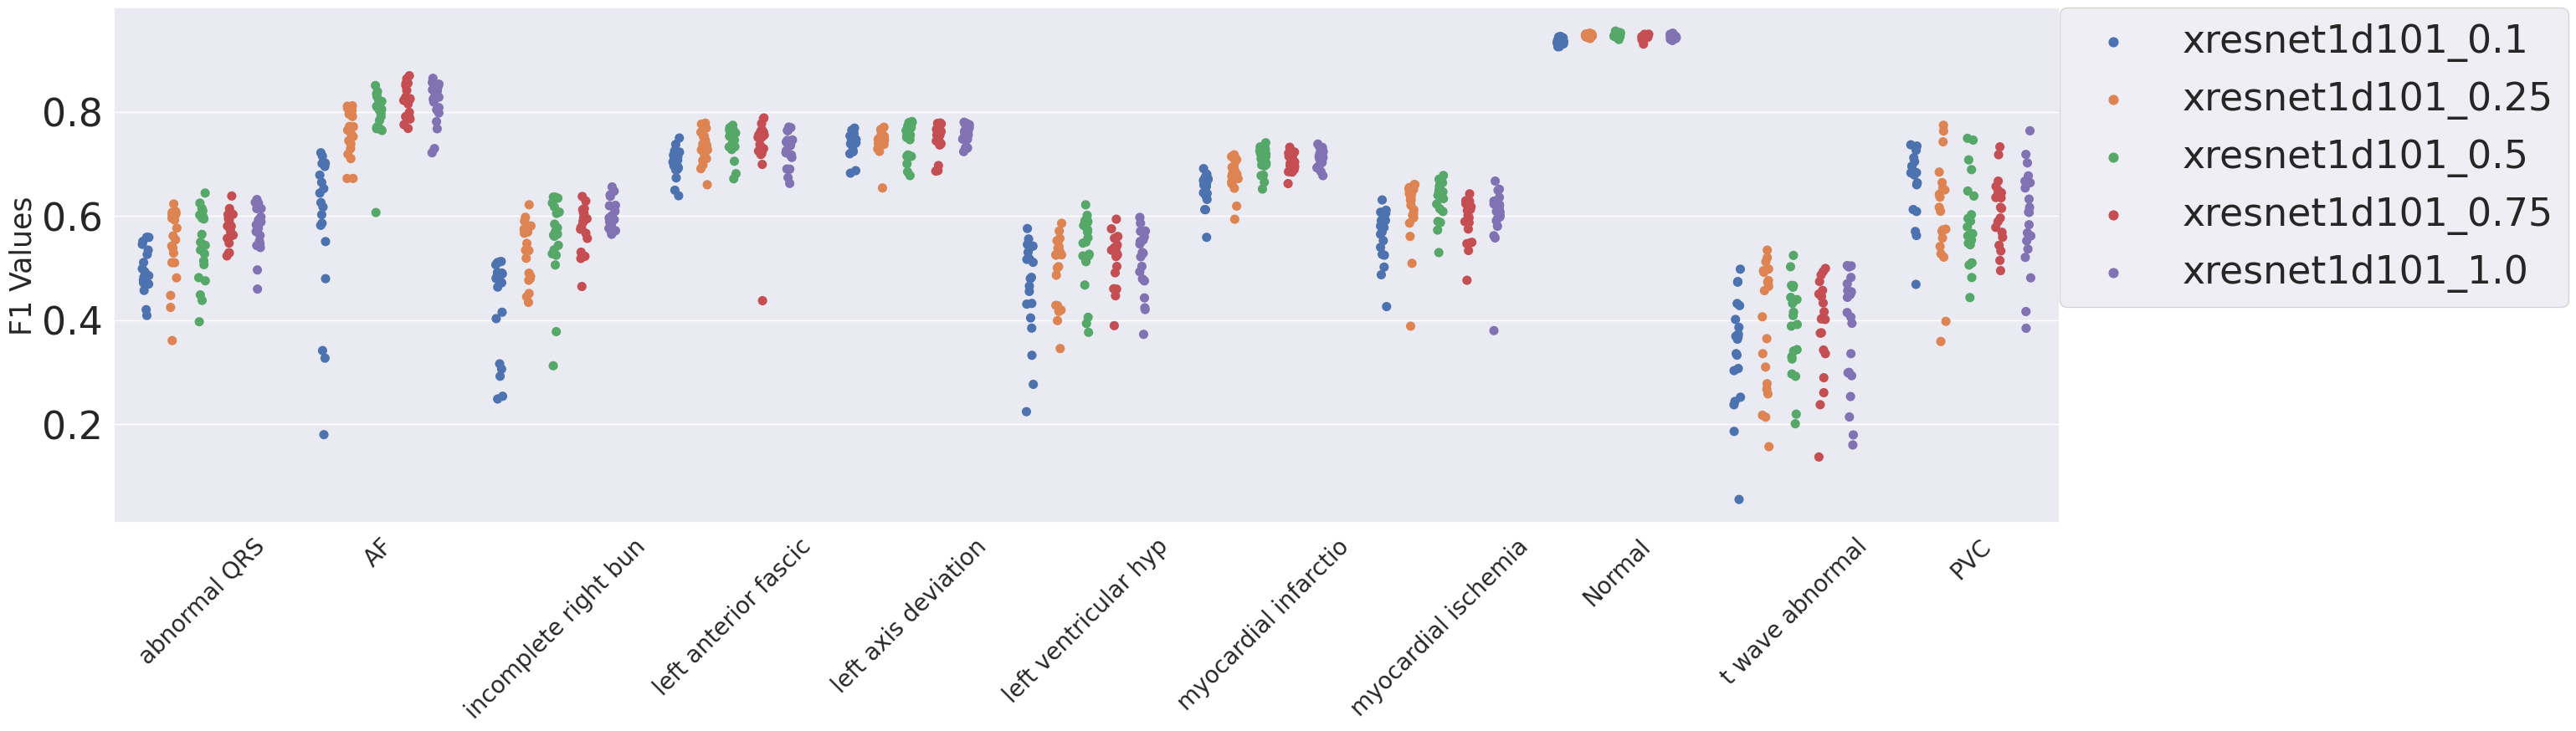

In [4]:
for dataset in datasets:
    model_name = "xresnet1d101"
    exp_df = get_scaling_experiments(model_name,dataset,dataset_numbers=False)
exp_df = exp_df.drop(columns=["dataset_name"])
plt = draw_scatter_plot(exp_df)
ax.set_title("Expriment Results for MiniRocket on CPSC", fontsize = 25)

In [ ]:
for dataset in datasets:
    model_name = "inception"
    exp_df = get_scaling_experiments(model_name,dataset,dataset_numbers=False)
exp_df = exp_df.drop(columns=["dataset_name"])
plt = draw_scatter_plot(exp_df)
# ax.set_title("Expriment Results for MiniRocket on CPSC", fontsize = 25)

In [ ]:
# compare inception and xresnet ( or any two models)
model_1 = "inception"
model_2 = "xresnet1d101"
exp_1 = get_scaling_experiments(model_1,dataset,dataset_numbers=False).drop(columns=["dataset_name"]).groupby("classifier_name").median()
exp_2 = get_scaling_experiments(model_2,dataset,dataset_numbers=False).drop(columns=["dataset_name"]).groupby("classifier_name").median()


In [ ]:
# get difference between the 20 model experiments for each disease
pd.DataFrame(exp_2.values-exp_1.values,columns = exp_1.columns,index=[int(np.float32(x.split("_")[1])*500) for x in exp_1.index])